### CSV to DF raw data ETL 코드

In [1]:
import pandas as pd
import io
import csv
import re

In [4]:
def safe_float(value):
    if not value: return 0.0
    s = str(value).replace(',', '').strip()
    if s in ['.', '', '-', 'nan']: return 0.0
    try:
        return float(s)
    except: return 0.0

def is_date_row(string):
    return bool(re.match(r'\d{4}[/.]\d{2}[/.]\d{2}', str(string)))

def get_header_map(row):
    """현재 행에서 각 컬럼 명칭이 몇 번째 인덱스에 있는지 맵 생성"""
    mapping = {}
    for idx, col in enumerate(row):
        name = col.strip()
        if name: mapping[name] = idx
    return mapping

def load_hts_dynamic_final(file_path):
    processed_data = []
    with open(file_path, 'r', encoding='cp949', errors='replace') as f:
        reader = csv.reader(f)
        all_rows = list(reader)

    h1_map, h2_map = {}, {}
    # 우리가 추출하고자 하는 25개 전체 컬럼 정의
    cols_h1 = ['일자', '구분', '종목번호', '수량', '거래대금', '미수발생/변제', '세전이자', '수수료', '연체료', '상대처', '변동금액', '대출일', '처리자']
    cols_h2 = ['상품', '적요', '종목명', '가격', '신용/대출금', '신용/대출이자', '예탁금이용료', '제세금', '대체계좌/채널', '의뢰자명', '최종금액', '만기일']

    i = 0
    while i < len(all_rows) - 1:
        row = all_rows[i]
        row_str = " ".join(map(str, row))
        
        # 1. 안내문구는 스킵하되 루프는 유지
        if "본 출력물은" in row_str:
            i += 1
            continue
            
        # 2. 제목 행이 나타나면 인덱스 맵 업데이트 (밀림 방지의 핵심)
        if "일자" in row and "구분" in row:
            h1_map = get_header_map(row)
            i += 1; continue
        if "상품" in row and "적요" in row:
            h2_map = get_header_map(row)
            i += 1; continue
            
        # 3. 데이터 행(날짜) 발견 시 파싱
        date_val = row[1].strip() if len(row) > 1 else ""
        if is_date_row(date_val):
            row1, row2 = all_rows[i], all_rows[i+1]
            record = {}
            # Row 1 (13개 열)
            for col in cols_h1:
                idx = h1_map.get(col)
                val = row1[idx] if idx is not None and idx < len(row1) else ""
                record[col] = safe_float(val) if col in ['수량', '거래대금', '수수료', '변동금액'] else val.strip()
            # Row 2 (12개 열)
            for col in cols_h2:
                idx = h2_map.get(col)
                val = row2[idx] if idx is not None and idx < len(row2) else ""
                record[col] = safe_float(val) if col in ['가격', '최종금액', '제세금'] else val.strip()
            
            # 통화 정보 보정 (의뢰자명 필드 활용)
            record['통화'] = record.get('의뢰자명', 'USD')
            processed_data.append(record)
            i += 2; continue
        i += 1
            
    return pd.DataFrame(processed_data)

# 실행 및 저장
df = load_hts_dynamic_final('./00RAW_DATA/1750.csv')
df.to_csv('./01DATA/00Transaction_History.csv', index=False, encoding='utf-8-sig')

print(f"✅ 총 {len(df)}건 완료.")

✅ 총 496건 완료.


In [3]:
df = pd.read_csv("./01DATA/00Transaction_History.csv")
df

,일자,구분,종목번호,수량,거래대금,미수발생/변제,세전이자,수수료,연체료,상대처,...,가격,신용/대출금,신용/대출이자,예탁금이용료,제세금,대체계좌/채널,의뢰자명,최종금액,만기일,통화
0,2025/01/02,해외증권_해외주식매도,US9119221029,11.0,1481.150,.,.,1.23,.,NaN,...,134.650,.,.,.,0.0,신한 SOL증권(Android),USD,2181.0,NaN,USD
1,2025/01/02,해외증권_해외주식매도,US1999081045,3.0,1268.260,.,.,1.05,.,NaN,...,422.753,.,.,.,0.0,신한 SOL증권(Android),USD,3448.0,NaN,USD
2,2025/01/02,해외증권_해외주식매도,US22266T1097,60.0,1330.815,.,.,1.10,.,NaN,...,22.180,.,.,.,0.0,신한 SOL증권(Android),USD,4778.0,NaN,USD
3,2025/01/02,해외증권_해외주식매도,BMG4809J1062,60.0,1412.400,.,.,1.17,.,NaN,...,23.540,.,.,.,0.0,신한 SOL증권(Android),USD,6189.0,NaN,USD
4,2025/01/02,해외증권_해외주식매수,US88642R1095,2.0,108.080,.,.,0.09,.,NaN,...,54.040,.,.,.,0.0,신한 SOL(HTS) 고객용,USD,6081.0,NaN,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,2026/02/05,외화RP원천징수,3500,0.0,580.000,.,.,0.00,.,NaN,...,0.000,.,.,.,580.0,NaN,NaN,0.0,NaN,NaN
488,2026/02/05,외화RP매수출금,USD,0.0,1081.460,.,.,0.00,.,NaN,...,1451.200,.,.,.,0.0,NaN,NaN,800.0,NaN,NaN
489,2026/02/05,외화RP매수출금,USD,0.0,800.000,.,.,0.00,.,NaN,...,1451.200,.,.,.,0.0,NaN,NaN,0.0,NaN,NaN
490,2026/02/05,외화RP매도입금,USD,0.0,400.000,.,.,0.00,.,NaN,...,1451.200,.,.,.,0.0,NaN,NaN,400.0,NaN,NaN


In [2]:
def clean_asset_number(value):
    """
    HTS 자산 파일 특유의 숫자 형식을 정제
    예: "15,892,620." -> 15892620.0
        "." -> 0.0
        "21.80%" -> 21.8
    """
    if not value: return 0.0
    s = str(value).strip()
    
    # 점(.) 하나만 있거나 빈 문자열, 하이픈 등은 0으로 처리
    if s in ['.', '', '-', 'nan']: return 0.0
    
    # 쉼표(,)와 퍼센트(%) 제거
    s = s.replace(',', '').replace('%', '')
    
    # 끝에 붙은 점(.) 제거 (예: "100." -> "100")
    if s.endswith('.'):
        s = s[:-1]
        
    try:
        return float(s)
    except ValueError:
        return 0.0

def is_date_format(string):
    """YYYY.MM.DD 형식 확인"""
    return bool(re.match(r'\d{4}[.]\d{2}[.]\d{2}', str(string)))

def load_asset_summary(file_path):
    processed_data = []
    
    # 1. 파일 읽기 (CP949 인코딩 대응)
    with open(file_path, 'r', encoding='cp949', errors='replace') as f:
        reader = csv.reader(f)
        all_rows = list(reader)

    header_map = {}
    header_found = False
    
    # 추출할 주요 컬럼 리스트 (파일에 존재하는 실제 헤더명)
    target_cols = [
        '조회일자', '순자산', '입금고', '출금고', '손익', '수익률', 
        '자산', '부채', '예수금잔고', '주식/파생/채권 등', 
        '위탁순자산', '상품잔고', '금융상품', '누적손익', '누적수익률'
    ]

    for i, row in enumerate(all_rows):
        # 1. 안내 문구(Footer) 나오면 종료
        row_str = "".join(row)
        if "본 출력물은" in row_str:
            break
            
        # 2. 헤더 찾기 ('조회일자'가 포함된 행)
        if not header_found:
            if "조회일자" in row:
                # 동적 헤더 매핑 생성
                for idx, col_name in enumerate(row):
                    clean_name = col_name.strip()
                    if clean_name in target_cols:
                        header_map[clean_name] = idx
                header_found = True
            continue
            
        # 3. 데이터 파싱
        # 첫 번째 컬럼이 날짜 형식인 경우만 처리
        date_val = row[0].strip() if len(row) > 0 else ""
        
        if is_date_format(date_val):
            record = {}
            for col in target_cols:
                # 헤더 맵에 있는 컬럼만 추출
                if col in header_map:
                    idx = header_map[col]
                    val = row[idx] if idx < len(row) else ""
                    
                    # 날짜 컬럼은 문자열 그대로, 나머지는 숫자로 변환
                    if col == '조회일자':
                        record[col] = val
                    else:
                        record[col] = clean_asset_number(val)
            
            processed_data.append(record)

    df = pd.DataFrame(processed_data)
    
    # 날짜 형식 변환
    if '조회일자' in df.columns:
        df['조회일자'] = pd.to_datetime(df['조회일자'], format='mixed', errors='coerce')
        
    return df

# --- 실행 및 결과 확인 ---
if __name__ == "__main__":
    file_name = './00RAW_DATA/1721.csv'
    
    try:
        df_asset = load_asset_summary(file_name)
        
        print(f"✅ 자산 데이터 전처리 완료: 총 {len(df_asset)}건")
        
        # 파일 저장
        df_asset.to_csv('./01DATA/01Asset_Summary.csv', index=False, encoding='utf-8-sig')
        print("📂 저장 완료")
        
    except Exception as e:
        print(f"❌ 오류 발생: {e}")

✅ 자산 데이터 전처리 완료: 총 15건
📂 저장 완료


In [5]:
df_asset

,조회일자,순자산,입금고,출금고,손익,수익률,자산,부채,예수금잔고,주식/파생/채권 등,위탁순자산,상품잔고,금융상품,누적손익,누적수익률
0,2025-01-01,15892620.0,0.0,0.0,0.0,0.00,15892620.0,0.0,0.0,0.0,0.0,1472366.0,0.0,0.0,0.00
1,2025-01-31,15151059.0,0.0,300000.0,-441561.0,-2.78,15151059.0,0.0,0.0,0.0,2461638.0,6760958.0,0.0,-441561.0,-2.78
2,2025-02-28,11959067.0,1400000.0,3600000.0,-991992.0,-5.99,11959067.0,0.0,0.0,0.0,54.0,54.0,0.0,-1433553.0,-8.29
3,2025-03-31,12048504.0,332873.0,0.0,-243436.0,-1.98,12048504.0,0.0,0.0,0.0,333124.0,333094.0,0.0,-1676989.0,-9.51
4,2025-04-30,12982789.0,1400000.0,0.0,-465715.0,-3.46,12982789.0,0.0,1488.0,0.0,395784.0,394160.0,0.0,-2142704.0,-11.26
5,2025-05-31,21892940.0,8996194.0,0.0,-86043.0,-0.39,21892940.0,0.0,0.0,0.0,4594642.0,2550097.0,0.0,-2228747.0,-7.95
6,2025-06-30,24214026.0,1400000.0,150000.0,1071086.0,4.60,24214026.0,0.0,0.0,0.0,4704912.0,1476295.0,0.0,-1157661.0,-3.93
7,2025-07-31,24177016.0,0.0,3264714.0,3227704.0,13.33,24177016.0,0.0,3347.0,0.0,7562.0,4214.0,0.0,2070043.0,7.04
8,2025-08-31,29644914.0,1900000.0,0.0,3567898.0,13.68,29644914.0,0.0,0.0,0.0,208510.0,208488.0,0.0,5637941.0,18.00
9,2025-09-30,27231298.0,1000000.0,1673105.0,-1740511.0,-5.68,27231298.0,0.0,0.0,0.0,0.0,0.0,0.0,3897430.0,12.06


In [5]:
def parse_portfolio_clean(file_path):
    # 1. 파일 읽기 (인코딩 자동 감지)
    encodings = ['cp949', 'utf-8', 'euc-kr']
    content = ""
    for enc in encodings:
        try:
            with open(file_path, 'r', encoding=enc) as f:
                content = f.read()
            break
        except UnicodeDecodeError:
            continue
            
    # 최후의 수단
    if not content:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            content = f.read()

    # 2. 헤더 찾기
    f_io = io.StringIO(content)
    lines = f_io.readlines()
    
    header_idx = -1
    for i, line in enumerate(lines):
        if "종목코드" in line and "잔고수량" in line:
            header_idx = i
            break
            
    if header_idx == -1: return None, "헤더를 찾을 수 없습니다."

    # 3. 데이터프레임 변환
    f_io.seek(0)
    try:
        df = pd.read_csv(f_io, skiprows=header_idx)
    except Exception as e:
        return None, str(e)

    # 4. 데이터 추출 및 필터링
    records = []
    
    # 2줄씩 처리
    for i in range(1, len(df), 2):
        if i+1 >= len(df): break
        
        row_a = df.iloc[i]
        row_b = df.iloc[i+1]
        
        code = str(row_a.iloc[1])
        name = str(row_b.iloc[1])
        
        # --- 필터링 로직 (Filtering) ---
        # 1. 빈 값 제외
        if code == 'nan': continue
        
        # 2. 합계/소계 라인 제외
        if "합계" in code or "소계" in code: continue
        
        # 3. 푸터(안내 문구) 제외 (User Request)
        footer_keywords = ["출력", "감사합니다", "본 출력물", "안내"]
        is_footer = False
        for kw in footer_keywords:
            if kw in code or kw in name:
                is_footer = True
                break
        if is_footer: continue
        # -------------------------------

        def clean(val):
            if pd.isna(val): return ""
            return str(val).strip().replace(',', '')

        item = {
            # Row 1 (상단)
            '종목코드': clean(row_a.iloc[1]),
            '잔고수량': clean(row_a.iloc[4]),
            '주문가능수량': clean(row_a.iloc[6]),
            '평균단가': clean(row_a.iloc[7]),
            '매입금액': clean(row_a.iloc[9]),
            '미실현손익': clean(row_a.iloc[10]),
            '신용금액': clean(row_a.iloc[11]),
            '매수일': clean(row_a.iloc[14]),
            '매입환율': clean(row_a.iloc[15]),
            
            # Row 2 (하단)
            '종목명': clean(row_b.iloc[1]),
            '구분': clean(row_b.iloc[4]),
            '보유비중': clean(row_b.iloc[6]),
            '현재가': clean(row_b.iloc[7]),
            '평가금액': clean(row_b.iloc[9]),
            '수익률': clean(row_b.iloc[10]),
            '대출일': clean(row_b.iloc[11]),
            '만기일': clean(row_b.iloc[14]),
            '현재환율': clean(row_b.iloc[15])
        }
        records.append(item)

    return pd.DataFrame(records), "성공"

# 실행
df, msg = parse_portfolio_clean('00RAW_DATA/17100001.csv')

if df is not None:
    print("✅ 데이터 추출 완료 (18개 항목)")
    df.to_csv('./01DATA/02Portfolio_Holdings.csv', index=False, encoding='utf-8-sig')
    print("📂 저장 완료")
else:
    print(f"❌ 오류: {msg}")

✅ 데이터 추출 완료 (18개 항목)
📂 저장 완료


In [8]:
df

,종목코드,잔고수량,주문가능수량,평균단가,매입금액,미실현손익,신용금액,매수일,매입환율,종목명,구분,보유비중,현재가,평가금액,수익률,대출일,만기일,현재환율
0,JP3637270004,194,194,1683.,3078926,3562,0,,9.42,트레져팩토리,현금,.00,1704.,3082488,.12,,,9.32
1,US14888U1016,63,63,23.,2138631,115673,0,,1447.15,캐털리스트 파머슈티컬스(CATALYST PHARMACEUTICALS..,현금,.00,24.,2254304,5.41,,,1464.10
2,US33817P4054,95,95,19.,2536445,-400031,0,,1400.84,핏라이프 브랜즈(FITLIFE BRANDS INC),현금,.00,15.,2136414,-15.77,,,1464.10
3,US8085248628,82,82,24.,2930366,-6998,0,,1466.40,SCHWAB SHORT TERM US TREASURY,현금,.00,24.,2923368,-0.24,,,1464.10
4,US88642R1095,161,161,49.,11121742,4518286,0,,1388.12,타이드워터(TIDEWATER INC NEW),현금,.00,66.,15640028,40.63,,,1464.10
5,US9119221029,17,17,122.,3014336,-312560,0,,1442.48,유나이티드 스테이츠 라임 앤드 미네랄스(UNITED ST..,현금,.00,108.,2701776,-10.37,,,1464.10
6,US93627C1018,24,24,76.,2611273,517801,0,,1424.00,워리어 멧 콜(WARRIOR MET COAL INC),현금,.00,89.,3129074,19.83,,,1464.10


# Add cash to portfolio

In [6]:
def update_portfolio_with_cash(asset_file, holdings_file, output_file='03Portfolio_with_Cash.csv'):
    """
    자산 요약(Asset Summary)과 주식 보유 현황(Holdings)의 차액을 계산하여
    '현금 및 RP' 항목을 자동으로 추가하고 비중을 재계산하는 함수
    """
    print("🔄 포트폴리오 현금 통합 작업 시작...")
    
    try:
        # 1. 데이터 로드
        df_asset = pd.read_csv(asset_file)
        df_holdings = pd.read_csv(holdings_file)
        
        # 2. 최신 순자산 총액 가져오기 (가장 최근 날짜 기준)
        if '조회일자' in df_asset.columns:
            df_asset['조회일자'] = pd.to_datetime(df_asset['조회일자'])
            latest_asset = df_asset.sort_values('조회일자').iloc[-1]
        else:
            latest_asset = df_asset.iloc[-1]
            
        total_net_asset = float(str(latest_asset['순자산']).replace(',', ''))
        
        # 3. 주식 평가액 총합 계산
        total_stock_eval = df_holdings['평가금액'].sum()
        
        # 4. 현금(Gap) 계산: 순자산 - 주식평가액
        cash_amount = total_net_asset - total_stock_eval
        
        print(f"   - 총 순자산: {total_net_asset:,.0f} 원")
        print(f"   - 주식 평가: {total_stock_eval:,.0f} 원")
        print(f"   - 산출 현금: {cash_amount:,.0f} 원")
        
        # 5. 현금 행(Row) 생성
        cash_row = {col: 0 for col in df_holdings.columns} # 기존 컬럼 구조 유지
        cash_row.update({
            '종목명': '현금 및 RP (USD/KRW)',
            '종목코드': 'CASH',
            '평가금액': cash_amount,
            '매입금액': cash_amount, # 현금은 매입가=평가가 가정
            '보유수량': 1,
            '현재가': cash_amount,
            '구분': '현금'
        })
        
        # 6. 데이터프레임 병합
        df_full = pd.concat([df_holdings, pd.DataFrame([cash_row])], ignore_index=True)
        
        # 7. 비중(Weight) 재계산
        df_full['보유비중'] = (df_full['평가금액'] / total_net_asset * 100).round(2)
        
        # 8. 저장
        df_full.to_csv("./01DATA/"+output_file, index=False, encoding='utf-8-sig')
        print(f"✅ 저장 완료: {output_file} (현금 비중 {df_full.iloc[-1]['보유비중']}%)")
        
        return df_full

    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        return None

# 실행 예시
update_portfolio_with_cash('./01DATA/01Asset_Summary.csv', './01DATA/02Portfolio_Holdings.csv')

🔄 포트폴리오 현금 통합 작업 시작...
   - 총 순자산: 34,558,564 원
   - 주식 평가: 32,354,725 원
   - 산출 현금: 2,203,839 원
✅ 저장 완료: 03Portfolio_with_Cash.csv (현금 비중 6.38%)


,종목코드,잔고수량,주문가능수량,평균단가,매입금액,미실현손익,신용금액,매수일,매입환율,종목명,구분,보유비중,현재가,평가금액,수익률,대출일,만기일,현재환율,보유수량
0,JP3637270004,194,194,1683.0,3078926.0,60592,0,NaN,9.42,트레져팩토리,현금,9.08,1715.0,3139518.0,1.97,NaN,NaN,9.43,NaN
1,US14888U1016,63,63,23.0,2138631.0,82860,0,NaN,1447.15,캐털리스트 파머슈티컬스(CATALYST PHARMACEUTICALS..,현금,6.43,24.0,2221491.0,3.87,NaN,NaN,1457.70,NaN
2,US33817P4054,95,95,19.0,2536445.0,-547851,0,NaN,1400.84,핏라이프 브랜즈(FITLIFE BRANDS INC),현금,5.75,14.0,1988594.0,-21.60,NaN,NaN,1457.70,NaN
3,US8085248628,82,82,24.0,2930366.0,-14996,0,NaN,1466.40,SCHWAB SHORT TERM US TREASURY,현금,8.44,24.0,2915370.0,-0.51,NaN,NaN,1457.70,NaN
4,US88642R1095,161,161,49.0,11121742.0,5100010,0,NaN,1388.12,타이드워터(TIDEWATER INC NEW),현금,46.94,69.0,16221752.0,45.86,NaN,NaN,1457.70,NaN
5,US9119221029,17,17,122.0,3014336.0,-349894,0,NaN,1442.48,유나이티드 스테이츠 라임 앤드 미네랄스(UNITED ST..,현금,7.71,107.0,2664442.0,-11.61,NaN,NaN,1457.70,NaN
6,US93627C1018,24,24,76.0,2611273.0,592285,0,NaN,1424.00,워리어 멧 콜(WARRIOR MET COAL INC),현금,9.27,91.0,3203558.0,22.68,NaN,NaN,1457.70,NaN
7,CASH,0,0,0.0,2203839.0,0,0,0.0,0.00,현금 및 RP (USD/KRW),현금,6.38,2203839.0,2203839.0,0.00,0.0,0.0,0.00,1.0


# Visualize

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import platform

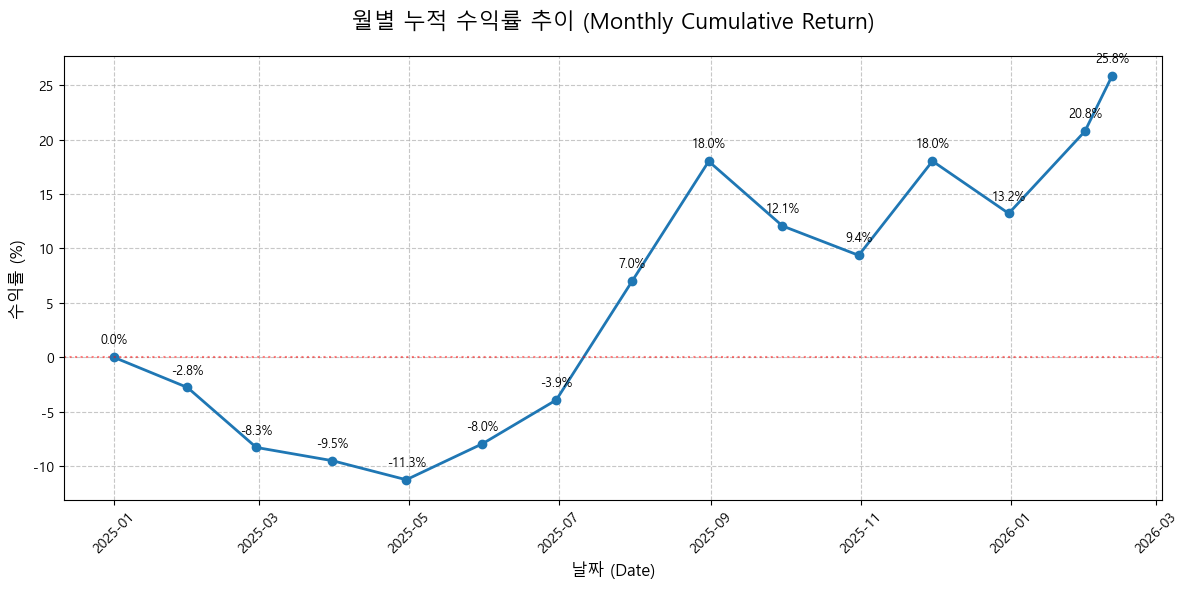

✅ 월별 누적 수익률 차트가 생성되었습니다.


In [3]:
# ---------------------------------------------------------
# 1. 환경 설정 (한글 폰트)
# ---------------------------------------------------------
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 기준
plt.rcParams['axes.unicode_minus'] = False    # 마이너스 기호 깨짐 방지

# ---------------------------------------------------------
# 2. 데이터 로드 및 전처리
# ---------------------------------------------------------
# 이미 정리된 01Asset_Summary.csv 파일을 로드합니다.
df_asset = pd.read_csv('./01DATA/01Asset_Summary.csv')

# 날짜 컬럼을 datetime 형식으로 변환하고, 날짜순으로 정렬합니다.
df_asset['조회일자'] = pd.to_datetime(df_asset['조회일자'])
df_asset = df_asset.sort_values('조회일자')

# ---------------------------------------------------------
# 3. 시각화 (Line Chart)
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))

# 선 그래프 그리기
plt.plot(df_asset['조회일자'], df_asset['누적수익률'], 
         marker='o',          # 데이터 포인트에 원형 마커 표시
         linestyle='-',       # 실선
         color='#1f77b4',     # 파란색 계열
         linewidth=2,         # 선 굵기
         label='누적 수익률')

# 차트 제목 및 라벨 설정
plt.title('월별 누적 수익률 추이 (Monthly Cumulative Return)', fontsize=16, pad=20)
plt.xlabel('날짜 (Date)', fontsize=12)
plt.ylabel('수익률 (%)', fontsize=12)

# 그리드 및 축 설정
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45) # 날짜 라벨이 겹치지 않게 회전

# 각 포인트에 수치(%) 표시 (Annotation)
for i, txt in enumerate(df_asset['누적수익률']):
    plt.annotate(f"{txt:.1f}%", 
                 (df_asset['조회일자'].iloc[i], df_asset['누적수익률'].iloc[i]),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center',
                 fontsize=9)

# 0% 기준선 추가 (붉은 점선) - 수익/손실 분기점
plt.axhline(y=0, color='r', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

print("✅ 월별 누적 수익률 차트가 생성되었습니다.")

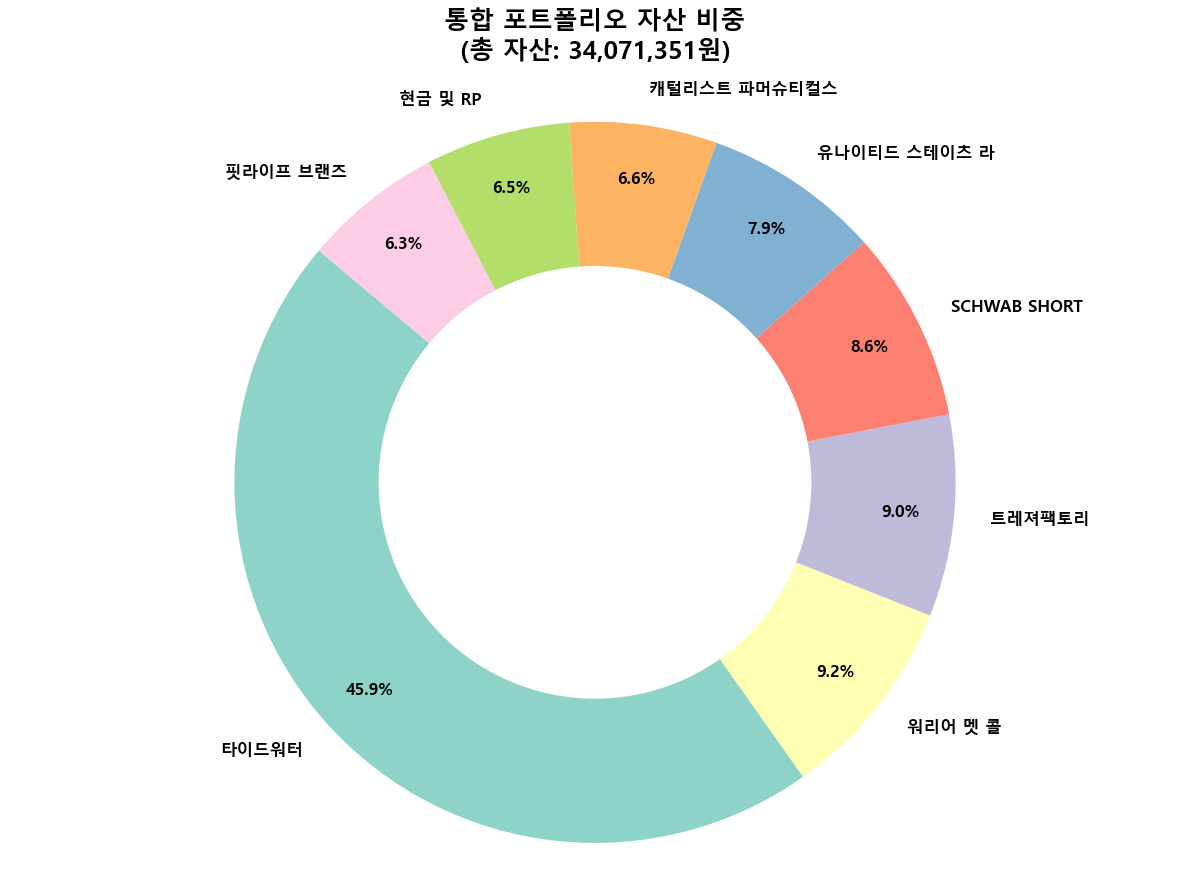

✅ 차트 생성 완료


In [12]:
# ---------------------------------------------------------
# 1. 파일 로드 (이전 단계에서 생성된 03 파일 사용)
# ---------------------------------------------------------
file_path = './01DATA/03Portfolio_with_Cash.csv'

# 한글 폰트 설정
system_name = platform.system()
font_family = 'Malgun Gothic' if system_name == 'Windows' else 'AppleGothic' if system_name == 'Darwin' else 'NanumGothic'
plt.rcParams['font.family'] = font_family
plt.rcParams['axes.unicode_minus'] = False

try:
    df = pd.read_csv(file_path)

    # ---------------------------------------------------------
    # 2. 시각화 (도넛 차트)
    # ---------------------------------------------------------
    # 평가금액 기준 정렬
    df_chart = df.sort_values('평가금액', ascending=False)
    
    # 데이터 준비
    labels = df_chart['종목명'].apply(lambda x: str(x).split('(')[0][:12])
    values = df_chart['평가금액']
    total_asset = values.sum()
    
    # 차트 그리기
    plt.figure(figsize=(12, 9))
    colors = plt.cm.Set3.colors
    
    wedges, texts, autotexts = plt.pie(values, labels=labels, autopct='%1.1f%%',
                                       startangle=140, colors=colors, pctdistance=0.85,
                                       textprops={'fontsize': 12, 'weight': 'bold'})
    
    # 도넛 스타일 (가운데 원)
    centre_circle = plt.Circle((0,0), 0.60, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    plt.title(f'통합 포트폴리오 자산 비중\n(총 자산: {total_asset:,.0f}원)', 
              fontsize=18, fontweight='bold', pad=20)
    
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    print("✅ 차트 생성 완료")

except FileNotFoundError:
    print(f"❌ '{file_path}' 파일이 없습니다. 이전 단계(현금 통합 코드)를 먼저 실행해주세요.")

# Create Daily Asset Timeline

In [13]:
import numpy as np


In [7]:
# ---------------------------------------------------------
# 1. 환경 설정 (한글 폰트)
# ---------------------------------------------------------
system_name = platform.system()
font_family = 'Malgun Gothic' if system_name == 'Windows' else 'AppleGothic' if system_name == 'Darwin' else 'NanumGothic'
plt.rcParams['font.family'] = font_family
plt.rcParams['axes.unicode_minus'] = False

def create_hybrid_ledger(asset_file, tx_file, output_file='./01DATA/04Daily_Asset_Ledger.csv'):
    print("🚀 하이브리드 일별 자산 장부 구축 시작...")
    
    # 1. 데이터 로드
    try:
        df_anchor = pd.read_csv(asset_file)
        df_tx = pd.read_csv(tx_file)
    except Exception as e:
        return None, f"파일 로드 실패: {e}"

    # ---------------------------------------------------------
    # 2. Anchor(자산 요약) 전처리
    # ---------------------------------------------------------
    if '조회일자' in df_anchor.columns:
        df_anchor['Date'] = pd.to_datetime(df_anchor['조회일자'])
    else:
        df_anchor['Date'] = pd.to_datetime(df_anchor.iloc[:, 0])
        
    def clean_num(x):
        return float(str(x).replace(',', ''))
        
    df_anchor['NetAsset'] = df_anchor['순자산'].apply(clean_num)
    df_anchor = df_anchor.sort_values('Date').drop_duplicates('Date', keep='last')
    
    # 기준일자 리스트 (Anchors)
    anchors = df_anchor.set_index('Date')['NetAsset']
    
    # ---------------------------------------------------------
    # 3. Transaction(거래 내역) 전처리 & External Flow 추출
    # ---------------------------------------------------------
    df_tx['Date'] = pd.to_datetime(df_tx['일자'])
    
    # 검색을 위해 구분+적요 합치기
    df_tx['Type_Full'] = df_tx['구분'].fillna('') + " " + df_tx['적요'].fillna('')
    df_tx['Amount'] = df_tx['변동금액'].apply(clean_num)
    
    # [핵심 로직] 외부 자금 흐름(External Flow) 판별 함수
    def get_flow(row):
        t = row['Type_Full']
        amt = row['Amount']
        
        # 1. 입금 성격 (+): 순자산 증가
        if any(x in t for x in ['입금', '입고', '배당', '이자']):
            # 제외: 내부 이동 (RP, 환전, 매도대금, 결제 등)
            if any(x in t for x in ['RP', '환전', '매도', '결제', '정산']):
                # 단, RP이자, 예탁금이용료 등은 수익이므로 포함
                if '이자' in t or '이용료' in t: return amt
                return 0
            return amt
            
        # 2. 출금 성격 (-): 순자산 감소
        if any(x in t for x in ['출금', '출고', '세금', '세액']):
            # 제외: 내부 이동 (RP, 환전, 매수대금)
            if any(x in t for x in ['RP', '환전', '매수']):
                 if '세금' in t or '세액' in t: return -abs(amt) # 세금은 차감
                 return 0
            return -abs(amt) # 출금은 마이너스 처리
            
        return 0

    df_tx['NetFlow'] = df_tx.apply(get_flow, axis=1)
    
    # 일별 Flow 합계
    daily_flow = df_tx.groupby('Date')['NetFlow'].sum()
    
    # ---------------------------------------------------------
    # 4. 타임라인 구축 (Hybrid Interpolation)
    # ---------------------------------------------------------
    # 전체 기간 설정 (시작일 ~ 오늘)
    start_date = df_anchor['Date'].min()
    end_date = max(df_anchor['Date'].max(), pd.Timestamp.today())
    
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    ledger = pd.DataFrame(index=date_range)
    ledger.index.name = 'Date'
    
    # 데이터 매핑
    ledger['Anchor_Asset'] = anchors
    ledger['External_Flow'] = daily_flow
    ledger['External_Flow'] = ledger['External_Flow'].fillna(0)
    ledger['Calculated_Asset'] = np.nan # 초기화

    # Anchor 구간별 순회
    anchor_dates = ledger[ledger['Anchor_Asset'].notnull()].index
    
    if len(anchor_dates) == 0:
        return None, "Anchor 데이터가 없습니다."

    # 첫 구간 초기화
    prev_date = anchor_dates[0]
    prev_asset = ledger.loc[prev_date, 'Anchor_Asset']
    ledger.loc[prev_date, 'Calculated_Asset'] = prev_asset
    
    # 구간 루프
    for curr_date in anchor_dates[1:]:
        # 구간 정의: prev_date < Date <= curr_date
        period_mask = (ledger.index > prev_date) & (ledger.index <= curr_date)
        period_days = ledger.loc[period_mask].index
        
        curr_asset = ledger.loc[curr_date, 'Anchor_Asset']
        
        # 기간 내 총 유입/유출
        period_flows = ledger.loc[period_mask, 'External_Flow']
        total_flow = period_flows.sum()
        
        # 이론적 기말 잔고 (투자수익 0 가정)
        theoretical_end = prev_asset + total_flow
        
        # 평가 차액 (Valuation Gain/Loss) = 실제 기말 - 이론적 기말
        valuation_gain = curr_asset - theoretical_end
        
        # 일별 배분 (선형 보간)
        daily_gain = valuation_gain / len(period_days)
        
        # 일별 잔고 채우기
        running_asset = prev_asset
        for day in period_days:
            flow = ledger.loc[day, 'External_Flow']
            running_asset += flow + daily_gain
            ledger.loc[day, 'Calculated_Asset'] = running_asset
            
        # 오차 보정 (마지막 날은 Anchor 값으로 강제 일치)
        ledger.loc[curr_date, 'Calculated_Asset'] = curr_asset
        
        # 다음 루프 준비
        prev_date = curr_date
        prev_asset = curr_asset

    # 마지막 Anchor 이후 (미래 구간) 처리
    # Anchor가 없는 구간은 투자수익 0 가정, Flow만 반영
    last_anchor_date = anchor_dates[-1]
    if last_anchor_date < ledger.index[-1]:
        future_mask = ledger.index > last_anchor_date
        running_asset = ledger.loc[last_anchor_date, 'Anchor_Asset']
        for day in ledger[future_mask].index:
            flow = ledger.loc[day, 'External_Flow']
            running_asset += flow
            ledger.loc[day, 'Calculated_Asset'] = running_asset
            
    # ---------------------------------------------------------
    # 5. 저장 및 반환
    # ---------------------------------------------------------
    
    ledger = ledger.reset_index()
    ledger['Calculated_Asset'] = ledger['Calculated_Asset'].round(0)
    
    ledger.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"✅ 저장 완료: {output_file}")
    return ledger, "성공"

# 사용 예시
df_ledger, msg = create_hybrid_ledger('./01DATA/01Asset_Summary.csv', './01DATA/00Transaction_History.csv')

🚀 하이브리드 일별 자산 장부 구축 시작...
✅ 저장 완료: ./01DATA/04Daily_Asset_Ledger.csv


# Calculate MWR, TWR, MDD 

In [5]:
import pandas as pd
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import platform

In [8]:
def calculate_and_save_metrics(input_file, output_file):
    print("🧮 성과 지표 계산 시작...")
    
    # 1. 데이터 로드
    df = pd.read_csv(input_file)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    
    # ---------------------------------------------------------
    # A. TWR (시간가중수익률) 계산
    # ---------------------------------------------------------
    # 전일 자산(Start Value)
    df['Prev_Asset'] = df['Calculated_Asset'].shift(1)
    df.loc[df.index[0], 'Daily_Return'] = 0.0
    
    # 분모 = 전일 자산 + 당일 입출금(External Flow)
    denominator = df['Prev_Asset'] + df['External_Flow']
    
    # 일별 수익률 계산 (0 나누기 방지)
    mask = denominator != 0
    df.loc[mask, 'Daily_Return'] = (df.loc[mask, 'Calculated_Asset'] / denominator[mask]) - 1
    df['Daily_Return'] = df['Daily_Return'].fillna(0.0)
    
    # 누적 수익률 (Chain-linking)
    df['Cumulative_TWR'] = (1 + df['Daily_Return']).cumprod() - 1

    # (참고용) 단순 수익률 계산: (현재자산 / 총투입원금) - 1
    df['Invested_Principal'] = df['Calculated_Asset'].iloc[0] + df['External_Flow'].cumsum()
    df['Simple_Return'] = (df['Calculated_Asset'] / df['Invested_Principal']) - 1

    # ---------------------------------------------------------
    # B. MDD (최대 낙폭) 계산
    # ---------------------------------------------------------
    df['Peak'] = df['Calculated_Asset'].cummax()
    df['Drawdown'] = (df['Calculated_Asset'] - df['Peak']) / df['Peak']
    mdd_val = df['Drawdown'].min()

    # ---------------------------------------------------------
    # C. MWR (금액가중수익률, XIRR) 계산
    # ---------------------------------------------------------
    # 현금흐름 준비: [(-초기투자), (-중간입출금...), (+최종회수)]
    xirr_df = pd.DataFrame({'Date': df['Date'], 'Flow': -df['External_Flow']})
    xirr_df.loc[xirr_df.index[0], 'Flow'] = -df['Calculated_Asset'].iloc[0] # 초기 투자
    xirr_df.loc[xirr_df.index[-1], 'Flow'] += df['Calculated_Asset'].iloc[-1] # 최종 평가
    
    # 0인 흐름 제외 (최적화 속도 향상)
    xirr_data = xirr_df[xirr_df['Flow'] != 0]

    # XIRR 함수 정의
    def xnpv(rate, values, dates):
        if rate <= -1.0: return float('inf')
        min_date = min(dates)
        return sum([val / (1 + rate)**((date - min_date).days / 365.0) for val, date in zip(values, dates)])

    def xirr(values, dates):
        try:
            return optimize.newton(lambda r: xnpv(r, values, dates), 0.1)
        except:
            return None

    mwr_val = xirr(xirr_data['Flow'].values, xirr_data['Date'].tolist())

    # ---------------------------------------------------------
    # D. 결과 저장 및 출력
    # ---------------------------------------------------------
    df.to_csv(output_file, index=False, encoding='utf-8-sig')
    
    print(f"✅ 계산 완료 및 저장: {output_file}")
    print(f"   - TWR (시간가중): {df['Cumulative_TWR'].iloc[-1]*100:.2f}%")
    print(f"   - MWR (금액가중): {mwr_val*100:.2f}% (연환산)" if mwr_val else "   - MWR: 계산 실패")
    print(f"   - MDD (최대낙폭): {mdd_val*100:.2f}%")

if __name__ == "__main__":
    calculate_and_save_metrics('./01DATA/04Daily_Asset_Ledger.csv', './01DATA/05Performance_Data.csv')

🧮 성과 지표 계산 시작...
✅ 계산 완료 및 저장: ./01DATA/05Performance_Data.csv
   - TWR (시간가중): 26.97%
   - MWR (금액가중): 37.74% (연환산)
   - MDD (최대낙폭): -25.68%


📊 차트 생성 중...


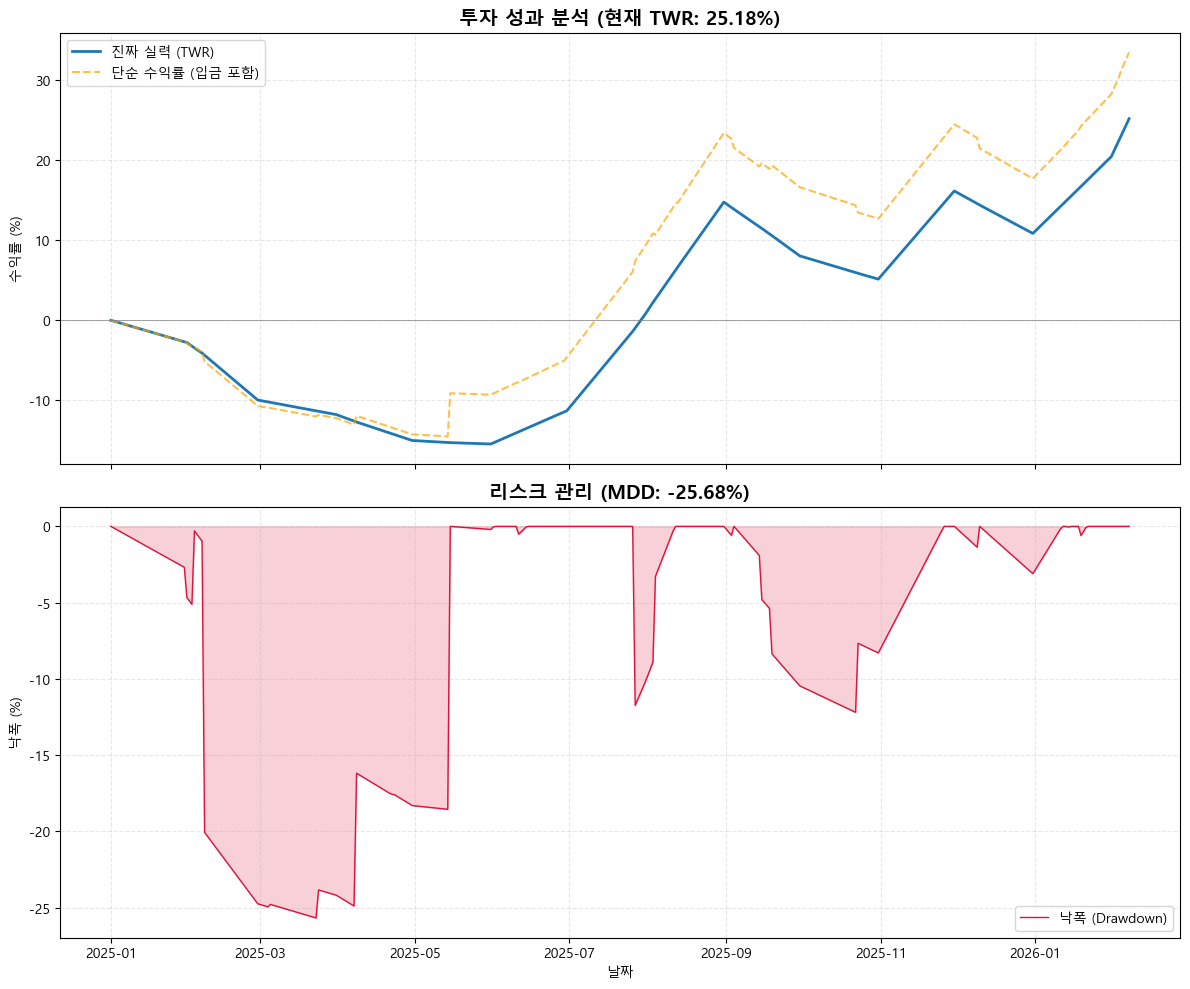

In [17]:
# 1. 환경 설정
system_name = platform.system()
font_family = 'Malgun Gothic' if system_name == 'Windows' else 'AppleGothic' if system_name == 'Darwin' else 'NanumGothic'
plt.rcParams['font.family'] = font_family
plt.rcParams['axes.unicode_minus'] = False

def visualize_performance(input_file):
    print("📊 차트 생성 중...")
    
    # 데이터 로드
    try:
        df = pd.read_csv(input_file)
        df['Date'] = pd.to_datetime(df['Date'])
    except FileNotFoundError:
        print("❌ 데이터 파일이 없습니다. 'calc_metrics.py'를 먼저 실행해주세요.")
        return

    # 주요 지표 추출
    final_twr = df['Cumulative_TWR'].iloc[-1]
    final_mdd = df['Drawdown'].min()

    # ---------------------------------------------------------
    # 차트 그리기 (2단 구성)
    # ---------------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # 1. 수익률 차트
    ax1.plot(df['Date'], df['Cumulative_TWR'] * 100, label='진짜 실력 (TWR)', color='#1f77b4', linewidth=2)
    ax1.plot(df['Date'], df['Simple_Return'] * 100, label='단순 수익률 (입금 포함)', color='orange', linestyle='--', alpha=0.7)
    
    ax1.axhline(0, color='gray', linestyle='-', linewidth=0.5)
    ax1.set_ylabel('수익률 (%)')
    ax1.set_title(f'투자 성과 분석 (현재 TWR: {final_twr*100:.2f}%)', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle='--', alpha=0.3)
    
    # 2. MDD 차트
    ax2.fill_between(df['Date'], df['Drawdown'] * 100, 0, color='crimson', alpha=0.2)
    ax2.plot(df['Date'], df['Drawdown'] * 100, color='crimson', linewidth=1, label='낙폭 (Drawdown)')
    
    ax2.set_ylabel('낙폭 (%)')
    ax2.set_title(f'리스크 관리 (MDD: {final_mdd*100:.2f}%)', fontsize=14, fontweight='bold')
    ax2.legend(loc='lower right')
    ax2.grid(True, linestyle='--', alpha=0.3)
    
    plt.xlabel('날짜')
    plt.tight_layout()
    plt.show()
    # plt.savefig('my_investment_report.png') # 저장하려면 주석 해제

if __name__ == "__main__":
    visualize_performance('./01DATA/05Performance_Data.csv')

# Portfolio Time machine

In [18]:
import pandas as pd
import numpy as np
import os

def build_holdings_timeline(holdings_file, tx_file, output_file='06Daily_Holdings_Timeline.csv'):
    print(f"⏳ 포트폴리오 타임머신 가동: {holdings_file} & {tx_file} 로드 중...")
    
    # 1. 데이터 로드 및 유효성 검사
    if not os.path.exists(holdings_file) or not os.path.exists(tx_file):
        print(f"❌ 오류: 필요한 데이터 파일이 없습니다.")
        return

    df_current = pd.read_csv(holdings_file)
    df_tx = pd.read_csv(tx_file)

    # 2. 현재 보유량 매핑 (Anchor)
    # 종목코드 -> 현재수량
    current_holdings = df_current.groupby('종목코드')['잔고수량'].sum().to_dict()
    
    # 종목코드 -> 종목명 (가독성을 위한 매핑)
    code_to_name = df_current.set_index('종목코드')['종목명'].to_dict()
    # 거래 내역에만 있고 현재 잔고에는 없는 종목(전량 매도)도 이름을 찾기 위해 추가 매핑
    tx_code_map = df_tx[['종목번호', '종목명']].dropna().drop_duplicates('종목번호').set_index('종목번호')['종목명'].to_dict()
    code_to_name.update(tx_code_map)

    # 3. 거래 내역 전처리 (Flow Calculation)
    df_tx['Date'] = pd.to_datetime(df_tx['일자'])
    
    # 주식 매수/매도 필터링 ('매수', '매도', '장내' 키워드 등)
    mask_stock = df_tx['구분'].str.contains('매수|매도|장내', na=False) & df_tx['종목번호'].notnull()
    df_stock_tx = df_tx[mask_stock].copy()
    
    # 수량 변환 함수: 매수(+), 매도(-)
    def get_net_change(row):
        try:
            qty = float(str(row['수량']).replace(',', ''))
        except:
            qty = 0
        
        # 역산 로직을 위해 매도는 음수 처리 (나중에 역산할 때 뺄셈으로 활용)
        if '매도' in row['구분']:
            return -qty
        return qty 
        
    df_stock_tx['Change'] = df_stock_tx.apply(get_net_change, axis=1)
    
    # 일별/종목별 순매수량 집계 (Pivot)
    daily_changes = df_stock_tx.pivot_table(
        index='Date', 
        columns='종목번호', 
        values='Change', 
        aggfunc='sum'
    ).fillna(0)
    
    # 4. 타임라인 구축 (Back-tracing Logic)
    # 시작일: 2025-01-01 / 종료일: 거래 내역의 마지막 날짜 (또는 오늘)
    start_date = pd.Timestamp('2025-01-01')
    end_date = df_tx['Date'].max()
    if end_date < pd.Timestamp.today():
        end_date = pd.Timestamp.today() # 오늘까지 확장
        
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # 전체 종목 리스트 확보 (현재보유 + 과거거래)
    all_codes = set(current_holdings.keys()).union(set(daily_changes.columns))
    
    # 빈 타임라인 생성
    # daily_changes를 날짜에 맞춰 정렬 (없는 날은 0)
    daily_changes_aligned = daily_changes.reindex(date_range).fillna(0)
    
    # 결과 담을 배열 초기화 (속도를 위해 numpy 사용)
    col_list = list(all_codes)
    n_days = len(date_range)
    n_cols = len(col_list)
    holdings_values = np.zeros((n_days, n_cols))
    
    # 마지막 날짜(End Date)의 수량 세팅 (현재 보유량 기준)
    final_vector = np.zeros(n_cols)
    for i, code in enumerate(col_list):
        final_vector[i] = current_holdings.get(code, 0)
    holdings_values[-1] = final_vector
    
    # 변경 내역 배열화
    changes_values = daily_changes_aligned.reindex(columns=col_list).fillna(0).values
    
    # [핵심 로직] 뒤에서부터 앞으로 역산 (Back-propagation)
    # 어제 수량 = 오늘 수량 - 오늘 변동량
    # Holdings[t-1] = Holdings[t] - NetChange[t]
    # 주의: 여기서 NetChange[t]는 t일에 발생한 매수/매도.
    # 예: 오늘(t) 10주 매수해서 100주가 됨. 그럼 어제(t-1)는 90주였음.
    # 식: 90 = 100 - (+10) -> 맞음.
    for i in range(n_days - 2, -1, -1):
        holdings_values[i] = holdings_values[i+1] - changes_values[i+1]
        
    # 5. 최저점 보정 (Baseline Correction)
    # 1월 1일 이전에 매수했던 종목은 역산 시 마이너스(-)가 됨.
    # 각 종목별 최저값이 0이 되도록 전체를 들어 올림.
    min_values = np.min(holdings_values, axis=0)
    correction_vector = np.where(min_values < 0, -min_values, 0)
    
    holdings_values += correction_vector # 브로드캐스팅 덧셈
    
    # 6. 결과 저장
    df_result = pd.DataFrame(holdings_values, index=date_range, columns=col_list)
    
    # 종목명으로 컬럼 변경
    new_columns = []
    for col in df_result.columns:
        name = code_to_name.get(col, col)
        if isinstance(name, str):
            name = name.split('(')[0].strip() # 이름 뒤 지저분한 것 제거
        new_columns.append(name)
    df_result.columns = new_columns
    
    # 소수점 오차 정리
    df_result = df_result.round(6)
    
    # CSV 저장
    df_result.to_csv(output_file, encoding='utf-8-sig')
    print(f"✅ 생성 완료: {output_file}")
    
    # 보정 내역 출력
    corrected_indices = np.where(correction_vector > 0)[0]
    if len(corrected_indices) > 0:
        print("\n[알림] 2025-01-01 이전 보유 추정 종목이 보정되었습니다:")
        for idx in corrected_indices:
            print(f"- {new_columns[idx]}: +{correction_vector[idx]:.0f}주")

if __name__ == "__main__":
    build_holdings_timeline('./01DATA/02Portfolio_Holdings.csv', './01DATA/00Transaction_History.csv')

⏳ 포트폴리오 타임머신 가동: ./01DATA/02Portfolio_Holdings.csv & ./01DATA/00Transaction_History.csv 로드 중...
✅ 생성 완료: 06Daily_Holdings_Timeline.csv


# MA(Moving Average) Engine

# yfinance OHLCV

✅ 내 포트폴리오 로드 완료: 403일 (기간: 2025-01-01 ~ 2026-02-07)
📥 벤치마크 데이터 다운로드 중... (2025-01-01 ~ 2026-02-07)


C:\Users\admin\AppData\Local\Temp\ipykernel_30268\499016038.py:204: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\admin\AppData\Local\Temp\ipykernel_30268\499016038.py:204: UserWarning: Glyph 51061 (\N{HANGUL SYLLABLE IG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\admin\AppData\Local\Temp\ipykernel_30268\499016038.py:204: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\admin\AppData\Local\Temp\ipykernel_30268\499016038.py:204: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\admin\AppData\Local\Temp\ipykernel_30268\499016038.py:204: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\admin\AppData\Local\Temp\ipykernel_30268\499016038.py:204: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) Arial.
  plt.tig

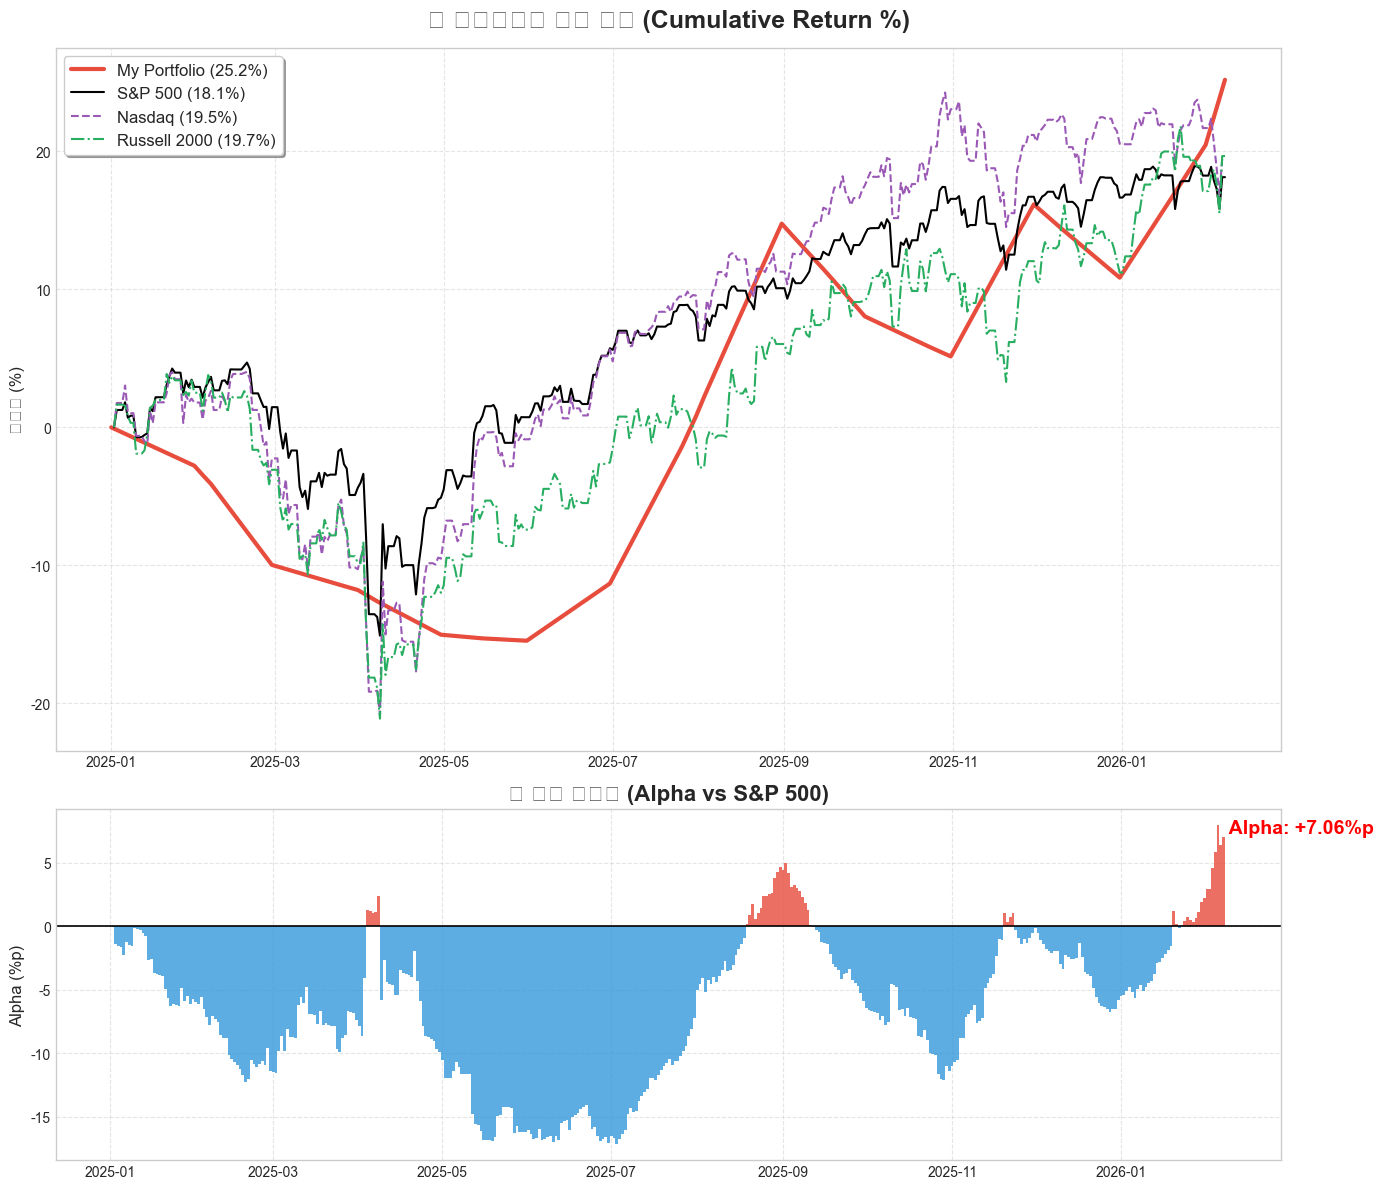

In [6]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import platform
import os

# =========================================================
# 1. 환경 설정 (Configuration)
# =========================================================
# 사용자 데이터 경로 설정
DATA_PATH = './01DATA/05Performance_Data.csv'

# 차트 스타일 및 폰트 설정
system_name = platform.system()
font_family = 'Malgun Gothic' if system_name == 'Windows' else 'AppleGothic'
plt.rcParams['font.family'] = font_family
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-whitegrid')

# =========================================================
# 2. 데이터 로드 함수
# =========================================================
def load_my_portfolio(file_path):
    """
    내 포트폴리오 데이터를 로드하고 전처리합니다.
    """
    if not os.path.exists(file_path):
        print(f"❌ 파일이 존재하지 않습니다: {file_path}")
        return None

    try:
        # CSV 로드 (Date를 인덱스로)
        df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
        
        # 'Cumulative_TWR' 컬럼 찾기 (대소문자 무시)
        target_col = None
        for col in df.columns:
            if 'cumulative_twr' in col.lower():
                target_col = col
                break
        
        if target_col is None:
            print(f"❌ 'Cumulative_TWR' (누적수익률) 컬럼을 찾을 수 없습니다. (현재 컬럼: {list(df.columns)})")
            return None

        # [중요] 0.19 -> 19.0(%) 로 단위 변환
        my_series = df[target_col] * 100
        my_series.name = 'My Portfolio'
        
        print(f"✅ 내 포트폴리오 로드 완료: {len(my_series)}일 (기간: {my_series.index.min().date()} ~ {my_series.index.max().date()})")
        return my_series

    except Exception as e:
        print(f"❌ 데이터 로드 중 오류 발생: {e}")
        return None

def download_benchmark_data(start_date, end_date):
    """
    3대 지수 데이터를 다운로드하고 누적 수익률(%)로 변환합니다.
    """
    tickers = {
        'S&P 500': '^GSPC', 
        'Nasdaq': '^IXIC', 
        'Russell 2000': '^RUT'
    }
    
    # yfinance는 종료일 다음날까지 요청해야 함
    yf_end = end_date + pd.Timedelta(days=1)
    
    print(f"📥 벤치마크 데이터 다운로드 중... ({start_date.date()} ~ {end_date.date()})")
    
    benchmark_dfs = {}
    
    for name, ticker in tickers.items():
        try:
            # 1. 데이터 다운로드 (auto_adjust=False로 Adj Close 확보)
            df = yf.download(ticker, start=start_date, end=yf_end, progress=False, auto_adjust=False)
            
            if df.empty:
                print(f"⚠️ {name} 데이터가 없습니다.")
                continue

            # 2. 가격 컬럼 추출 (yfinance 버전 호환성 처리)
            # Adj Close가 있으면 우선 사용, 없으면 Close 사용
            if 'Adj Close' in df.columns:
                price = df['Adj Close']
            elif 'Close' in df.columns:
                price = df['Close']
            else:
                # MultiIndex 등의 경우 대비
                price = df.iloc[:, 0]

            # Series 형태로 확실히 변환 (DataFrame인 경우 첫번째 열)
            if isinstance(price, pd.DataFrame):
                price = price.iloc[:, 0]

            # 3. 수익률 정규화 (시작일 = 0%)
            # 내 포트폴리오 시작일 기준 가격으로 나눔
            base_price = price.iloc[0]
            returns_pct = (price / base_price - 1) * 100
            returns_pct.name = name
            
            benchmark_dfs[name] = returns_pct
            
        except Exception as e:
            print(f"⚠️ {name} 처리 중 오류: {e}")
            continue
            
    return benchmark_dfs

# =========================================================
# 3. 메인 실행 로직
# =========================================================
def run_analysis():
    # 1. 내 데이터 로드
    my_data = load_my_portfolio(DATA_PATH)
    if my_data is None:
        return

    # 2. 벤치마크 데이터 다운로드
    start_date = my_data.index.min()
    end_date = my_data.index.max()
    benchmark_dict = download_benchmark_data(start_date, end_date)
    
    if not benchmark_dict:
        print("❌ 비교할 벤치마크 데이터가 없습니다.")
        return

    # 3. 데이터 병합 (날짜 동기화)
    # 내 데이터를 기준으로 Left Join (주말/휴일 등으로 빈 날짜는 전일 데이터로 채움)
    df_all = pd.DataFrame(my_data)
    
    for name, series in benchmark_dict.items():
        # 타임존 제거 (비교를 위해)
        if series.index.tz is not None:
            series.index = series.index.tz_localize(None)
            
        df_all = df_all.join(series, how='left')
    
    # NaN 결측치 채우기 (전일 데이터 유지 -> ffill)
    df_all = df_all.ffill()
    
    # 4. 알파(Alpha) 계산 (vs S&P 500)
    if 'S&P 500' in df_all.columns:
        df_all['Alpha'] = df_all['My Portfolio'] - df_all['S&P 500']
        final_alpha = df_all['Alpha'].iloc[-1]
    else:
        df_all['Alpha'] = 0
        final_alpha = 0
        
    final_returns = df_all.iloc[-1]

    # =========================================================
    # 4. 시각화 (Visualization)
    # =========================================================
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [2, 1]})
    
    # [차트 1] 누적 수익률 비교
    # 색상 지정
    colors = {'My Portfolio': '#e74c3c', 'S&P 500': 'black', 'Nasdaq': '#9b59b6', 'Russell 2000': '#27ae60'}
    linewidths = {'My Portfolio': 3.0, 'S&P 500': 1.5, 'Nasdaq': 1.5, 'Russell 2000': 1.5}
    linestyles = {'My Portfolio': '-', 'S&P 500': '-', 'Nasdaq': '--', 'Russell 2000': '-.'}

    for col in df_all.columns:
        if col == 'Alpha': continue
        
        ax1.plot(df_all.index, df_all[col], 
                 label=f"{col} ({final_returns[col]:.1f}%)",
                 color=colors.get(col, 'gray'),
                 linewidth=linewidths.get(col, 1),
                 linestyle=linestyles.get(col, '-'))

    ax1.set_title("📈 포트폴리오 성과 비교 (Cumulative Return %)", fontsize=18, fontweight='bold', pad=15)
    ax1.set_ylabel("수익률 (%)", fontsize=12)
    ax1.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)
    ax1.grid(True, linestyle='--', alpha=0.5)

    # [차트 2] Alpha (초과 수익)
    if 'S&P 500' in df_all.columns:
        # 양수는 빨강, 음수는 파랑
        bar_colors = ['#e74c3c' if x >= 0 else '#3498db' for x in df_all['Alpha']]
        ax2.bar(df_all.index, df_all['Alpha'], color=bar_colors, width=1.0, alpha=0.8)
        
        # 0선 강조
        ax2.axhline(0, color='black', linewidth=1.2)
        
        # 최종 알파 텍스트
        ax2.text(df_all.index[-1], final_alpha, f" Alpha: {final_alpha:+.2f}%p", 
                 color='red' if final_alpha > 0 else 'blue', 
                 fontweight='bold', fontsize=14, va='bottom')
        
        ax2.set_title("📊 초과 수익률 (Alpha vs S&P 500)", fontsize=16, fontweight='bold')
    else:
        ax2.text(0.5, 0.5, "S&P 500 데이터 없음", ha='center')

    ax2.set_ylabel("Alpha (%p)", fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.5)

    # 날짜 포맷 정리
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_analysis()